# ACCESS BARRA Grid Coordinate MATCH

## Overview

This notebook matches ACCESS and BARRA grid coordinates to farm boundaries defined by KML files.

For each farm (KML file), it:
1. Reads the KML file to extract farm boundary polygon
2. Identifies which ACCESS and BARRA grid coordinates sit within the farm boundary
3. Categorizes coordinates as:
   - **ACCESS only**: ACCESS grid points within farm boundary
   - **BARRA only**: BARRA grid points within farm boundary
   - **Both**: Grid points where both ACCESS and BARRA coordinates exist within farm boundary
4. Assigns letters to coordinates starting from north to south
5. Exports results to CSV files

## Input Files

- **KML files**: Farm boundary definitions (stored in configured folder)
- **ACCESS coordinates**: `AGDC_grid_coordinates.csv` (from ACCESS BARRA grid coordinates extraction notebook)
- **BARRA coordinates**: `BARRA_grid_coordinates.csv` (from ACCESS BARRA grid coordinates extraction notebook)

## Output

CSV files saved to the output directory:
- `{farm_name}_grid_coordinates_match.csv` - Categorized grid coordinates within farm boundary

## Section 1: Imports

In [8]:
import pandas as pd
import numpy as np
import os
import glob
import xml.etree.ElementTree as ET
from pathlib import Path
from shapely.geometry import Point, Polygon
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as MplPolygon
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## Section 2: Configuration

In [9]:
# Configuration
# ============================================================================

# Farm name (e.g., "Anameka") - used for output directory organization
FARM_NAME = "Anameka"

# KML files directory (folder containing KML files for farms)
# Change this path to point to the specific farm's KML files
KML_DIR = rf"C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files\{FARM_NAME}"

# Coordinate CSV files directory (where ACCESS and BARRA coordinate files are stored)
# These are the base coordinate files that don't change per farm
COORDINATES_DIR = r"C:\Users\ibian\Desktop\ClimAdapt\CMIP6"

# Output directory (includes farm name for organization)
OUTPUT_DIR = rf"C:\Users\ibian\Desktop\ClimAdapt\{FARM_NAME}"

# Coordinate CSV file names (fixed - these are the base coordinate files)
ACCESS_COORDS_FILE = "AGDC_grid_coordinates.csv"
BARRA_COORDS_FILE = "BARRA_grid_coordinates_all.csv"

print("="*70)
print("CONFIGURATION")
print("="*70)
print(f"Farm Name: {FARM_NAME}")
print(f"KML Directory: {KML_DIR}")
print(f"Coordinates Directory: {COORDINATES_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"ACCESS Coordinates File: {ACCESS_COORDS_FILE}")
print(f"BARRA Coordinates File: {BARRA_COORDS_FILE}")
print("="*70)

CONFIGURATION
Farm Name: Anameka
KML Directory: C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files\Anameka
Coordinates Directory: C:\Users\ibian\Desktop\ClimAdapt\CMIP6
Output Directory: C:\Users\ibian\Desktop\ClimAdapt\Anameka
ACCESS Coordinates File: AGDC_grid_coordinates.csv
BARRA Coordinates File: BARRA_grid_coordinates_all.csv


## Section 3: Load Grid Coordinates

In [10]:
# Load ACCESS and BARRA grid coordinates
print(f"\n{'='*70}")
print("Loading Grid Coordinates")
print(f"{'='*70}")

# Load ACCESS coordinates
access_coords_path = os.path.join(COORDINATES_DIR, ACCESS_COORDS_FILE)
if os.path.exists(access_coords_path):
    access_coords = pd.read_csv(access_coords_path)
    print(f"  [OK] Loaded ACCESS coordinates: {len(access_coords)} points")
    print(f"       Latitude range: {access_coords['latitude'].min():.4f} to {access_coords['latitude'].max():.4f}")
    print(f"       Longitude range: {access_coords['longitude'].min():.4f} to {access_coords['longitude'].max():.4f}")
else:
    print(f"  [ERROR] ACCESS coordinates file not found: {access_coords_path}")
    access_coords = None

# Load BARRA coordinates
barra_coords_path = os.path.join(COORDINATES_DIR, BARRA_COORDS_FILE)
if os.path.exists(barra_coords_path):
    barra_coords = pd.read_csv(barra_coords_path)
    print(f"  [OK] Loaded BARRA coordinates: {len(barra_coords)} points")
    print(f"       Latitude range: {barra_coords['latitude'].min():.4f} to {barra_coords['latitude'].max():.4f}")
    print(f"       Longitude range: {barra_coords['longitude'].min():.4f} to {barra_coords['longitude'].max():.4f}")
else:
    print(f"  [ERROR] BARRA coordinates file not found: {barra_coords_path}")
    barra_coords = None

if access_coords is None or barra_coords is None:
    print("\n  [ERROR] Cannot proceed without coordinate files")
    raise FileNotFoundError("Required coordinate CSV files not found")


Loading Grid Coordinates
  [OK] Loaded ACCESS coordinates: 138351 points
       Latitude range: -35.0000 to -13.5000
       Longitude range: 113.0000 to 129.0000
  [OK] Loaded BARRA coordinates: 138351 points
       Latitude range: -35.0000 to -13.5000
       Longitude range: 113.0000 to 129.0000


## Section 4: KML Parsing Functions

In [11]:
def parse_kml_file(kml_path):
    """
    Parse KML file and extract polygon coordinates.
    
    Parameters:
    -----------
    kml_path : str
        Path to KML file
    
    Returns:
    --------
    shapely.geometry.Polygon or None
        Polygon representing the farm boundary, or None if parsing fails
    """
    try:
        tree = ET.parse(kml_path)
        root = tree.getroot()
        
        # KML namespace
        ns = {'kml': 'http://www.opengis.net/kml/2.2'}
        
        # Find all coordinates in the KML file
        coordinates = []
        
        # Try different ways to find coordinates
        for coord_elem in root.findall('.//kml:coordinates', ns):
            coord_text = coord_elem.text.strip()
            if coord_text:
                # Parse coordinate string (format: "lon,lat,alt lon,lat,alt ...")
                coord_pairs = coord_text.split()
                for pair in coord_pairs:
                    parts = pair.split(',')
                    if len(parts) >= 2:
                        lon = float(parts[0])
                        lat = float(parts[1])
                        coordinates.append((lon, lat))
        
        # If no coordinates found with namespace, try without namespace
        if not coordinates:
            for coord_elem in root.findall('.//coordinates'):
                coord_text = coord_elem.text.strip()
                if coord_text:
                    coord_pairs = coord_text.split()
                    for pair in coord_pairs:
                        parts = pair.split(',')
                        if len(parts) >= 2:
                            lon = float(parts[0])
                            lat = float(parts[1])
                            coordinates.append((lon, lat))
        
        if len(coordinates) < 3:
            print(f"    [ERROR] Not enough coordinates found in KML (need at least 3, found {len(coordinates)})")
            return None
        
        # Create polygon (KML coordinates are lon,lat)
        polygon = Polygon(coordinates)
        
        if not polygon.is_valid:
            # Try to fix invalid polygon
            polygon = polygon.buffer(0)
        
        return polygon
        
    except Exception as e:
        print(f"    [ERROR] Failed to parse KML file: {e}")
        import traceback
        traceback.print_exc()
        return None

## Section 5: Match Coordinates to Farm Boundaries

In [12]:
def match_coordinates_to_farm(access_coords, barra_coords, farm_polygon, farm_name):
    """
    Match ACCESS and BARRA coordinates to farm boundary.
    
    Parameters:
    -----------
    access_coords : pd.DataFrame
        ACCESS grid coordinates (columns: latitude, longitude)
    barra_coords : pd.DataFrame
        BARRA grid coordinates (columns: latitude, longitude)
    farm_polygon : shapely.geometry.Polygon
        Farm boundary polygon
    farm_name : str
        Name of the farm
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with matched coordinates and categories
    """
    print(f"\n  Processing farm: {farm_name}")
    
    # Prepare polygon for faster point-in-polygon checks
    prep_polygon = prep(farm_polygon)
    
    # Check ACCESS coordinates
    access_within = []
    if access_coords is not None:
        for idx, row in access_coords.iterrows():
            point = Point(row['longitude'], row['latitude'])
            if prep_polygon.contains(point):
                access_within.append({
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'grid_type': 'ACCESS'
                })
    
    # Check BARRA coordinates
    barra_within = []
    if barra_coords is not None:
        for idx, row in barra_coords.iterrows():
            point = Point(row['longitude'], row['latitude'])
            if prep_polygon.contains(point):
                barra_within.append({
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'grid_type': 'BARRA'
                })
    
    print(f"    ACCESS points within boundary: {len(access_within)}")
    print(f"    BARRA points within boundary: {len(barra_within)}")
    
    # Create DataFrames
    access_df = pd.DataFrame(access_within) if access_within else pd.DataFrame(columns=['latitude', 'longitude', 'grid_type'])
    barra_df = pd.DataFrame(barra_within) if barra_within else pd.DataFrame(columns=['latitude', 'longitude', 'grid_type'])
    
    # Merge to find coordinates that have both ACCESS and BARRA
    # Round coordinates to avoid floating point precision issues
    access_df['lat_round'] = access_df['latitude'].round(6)
    access_df['lon_round'] = access_df['longitude'].round(6)
    barra_df['lat_round'] = barra_df['latitude'].round(6)
    barra_df['lon_round'] = barra_df['longitude'].round(6)
    
    # Find matches (coordinates that exist in both)
    merged = pd.merge(
        access_df[['latitude', 'longitude', 'lat_round', 'lon_round']],
        barra_df[['latitude', 'longitude', 'lat_round', 'lon_round']],
        on=['lat_round', 'lon_round'],
        how='inner',
        suffixes=('_access', '_barra')
    )
    
    # Create result DataFrame
    results = []
    
    # Add ACCESS-only coordinates
    access_only = access_df[~access_df.set_index(['lat_round', 'lon_round']).index.isin(
        merged.set_index(['lat_round', 'lon_round']).index
    )]
    for idx, row in access_only.iterrows():
        results.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'category': 'ACCESS only',
            'access_lat': row['latitude'],
            'access_lon': row['longitude'],
            'barra_lat': None,
            'barra_lon': None
        })
    
    # Add BARRA-only coordinates
    barra_only = barra_df[~barra_df.set_index(['lat_round', 'lon_round']).index.isin(
        merged.set_index(['lat_round', 'lon_round']).index
    )]
    for idx, row in barra_only.iterrows():
        results.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'category': 'BARRA only',
            'access_lat': None,
            'access_lon': None,
            'barra_lat': row['latitude'],
            'barra_lon': row['longitude']
        })
    
    # Add coordinates that have both ACCESS and BARRA
    for idx, row in merged.iterrows():
        results.append({
            'latitude': row['latitude_access'],
            'longitude': row['longitude_access'],
            'category': 'Both',
            'access_lat': row['latitude_access'],
            'access_lon': row['longitude_access'],
            'barra_lat': row['latitude_barra'],
            'barra_lon': row['longitude_barra']
        })
    
    if not results:
        print(f"    [WARNING] No coordinates found within farm boundary")
        return None
    
    # Create DataFrame
    result_df = pd.DataFrame(results)
    
    # Sort by latitude (north to south) for letter assignment
    result_df = result_df.sort_values('latitude', ascending=False).reset_index(drop=True)
    
    # Assign letters starting from north to south
    # Use uppercase letters A, B, C, ... Z, then AA, AB, etc. if needed
    letters = []
    for i in range(len(result_df)):
        if i < 26:
            letters.append(chr(65 + i))  # A-Z
        else:
            # AA, AB, AC, ... BA, BB, BC, ...
            # For i=26: AA, i=27: AB, i=52: BA, etc.
            first_idx = (i - 26) // 26
            second_idx = (i - 26) % 26
            first_letter = chr(65 + first_idx)
            second_letter = chr(65 + second_idx)
            letters.append(first_letter + second_letter)
    
    result_df['label'] = letters
    
    # Reorder columns
    result_df = result_df[['label', 'latitude', 'longitude', 'category', 
                          'access_lat', 'access_lon', 'barra_lat', 'barra_lon']]
    
    print(f"    Total matched coordinates: {len(result_df)}")
    print(f"      - ACCESS only: {len(result_df[result_df['category'] == 'ACCESS only'])}")
    print(f"      - BARRA only: {len(result_df[result_df['category'] == 'BARRA only'])}")
    print(f"      - Both: {len(result_df[result_df['category'] == 'Both'])}")
    
    return result_df

## Section 6: Process All KML Files

In [13]:
# Find all KML files in the KML directory
print(f"\n{'='*70}")
print("Processing KML Files")
print(f"{'='*70}")

kml_files = glob.glob(os.path.join(KML_DIR, "*.kml"))

if len(kml_files) == 0:
    print(f"  [ERROR] No KML files found in {KML_DIR}")
    print(f"  Please check the KML_DIR configuration")
else:
    print(f"  Found {len(kml_files)} KML file(s)")
    
    # Process each KML file
    for kml_file in kml_files:
        farm_name = Path(kml_file).stem  # Get filename without extension
        
        print(f"\n  {'='*60}")
        print(f"  Processing: {farm_name}")
        print(f"  KML file: {kml_file}")
        
        # Parse KML file
        farm_polygon = parse_kml_file(kml_file)
        
        if farm_polygon is None:
            print(f"    [ERROR] Failed to parse KML file, skipping...")
            continue
        
        print(f"    [OK] Parsed KML polygon with {len(farm_polygon.exterior.coords)} vertices")
        
        # Match coordinates to farm boundary
        matched_coords = match_coordinates_to_farm(
            access_coords, barra_coords, farm_polygon, farm_name
        )
        
        if matched_coords is None or len(matched_coords) == 0:
            print(f"    [WARNING] No coordinates matched for {farm_name}")
            continue
        
        # Save results to CSV
        output_filename = f"{farm_name}_grid_coordinates_match.csv"
        output_path = os.path.join(OUTPUT_DIR, output_filename)
        
        matched_coords.to_csv(output_path, index=False, encoding='utf-8')
        print(f"    [OK] Saved results: {output_path}")
        print(f"         Total coordinates: {len(matched_coords)}")
        
        # Print summary
        print(f"\n    Summary for {farm_name}:")
        print(f"      Coordinates by category:")
        category_counts = matched_coords['category'].value_counts()
        for cat, count in category_counts.items():
            print(f"        {cat}: {count}")
        
        print(f"      Latitude range: {matched_coords['latitude'].min():.4f} to {matched_coords['latitude'].max():.4f}")
        print(f"      Longitude range: {matched_coords['longitude'].min():.4f} to {matched_coords['longitude'].max():.4f}")
        print(f"      Labels assigned: {matched_coords['label'].min()} to {matched_coords['label'].max()} (north to south)")

print(f"\n{'='*70}")
print("[COMPLETE] All KML files processed!")
print(f"{'='*70}")


Processing KML Files
  Found 1 KML file(s)

  Processing: PROJ0025_GIS_Anameka_Farms
  KML file: C:\Users\ibian\Desktop\ClimAdapt\CMIP6\kml files\Anameka\PROJ0025_GIS_Anameka_Farms.kml
    [OK] Parsed KML polygon with 5 vertices

  Processing farm: PROJ0025_GIS_Anameka_Farms
    ACCESS points within boundary: 39
    BARRA points within boundary: 39
    Total matched coordinates: 39
      - ACCESS only: 0
      - BARRA only: 0
      - Both: 39
    [OK] Saved results: C:\Users\ibian\Desktop\ClimAdapt\Anameka\PROJ0025_GIS_Anameka_Farms_grid_coordinates_match.csv
         Total coordinates: 39

    Summary for PROJ0025_GIS_Anameka_Farms:
      Coordinates by category:
        Both: 39
      Latitude range: -31.7500 to -31.4500
      Longitude range: 117.4000 to 117.7000
      Labels assigned: A to Z (north to south)

[COMPLETE] All KML files processed!


## Section 7: Visualize Matched Coordinates with Grid Cells


Creating Visualizations

  Creating visualization for: PROJ0025_GIS_Anameka_Farms
  [OK] Saved visualization: C:\Users\ibian\Desktop\ClimAdapt\Anameka\PROJ0025_GIS_Anameka_Farms_grid_cells_with_labels.png


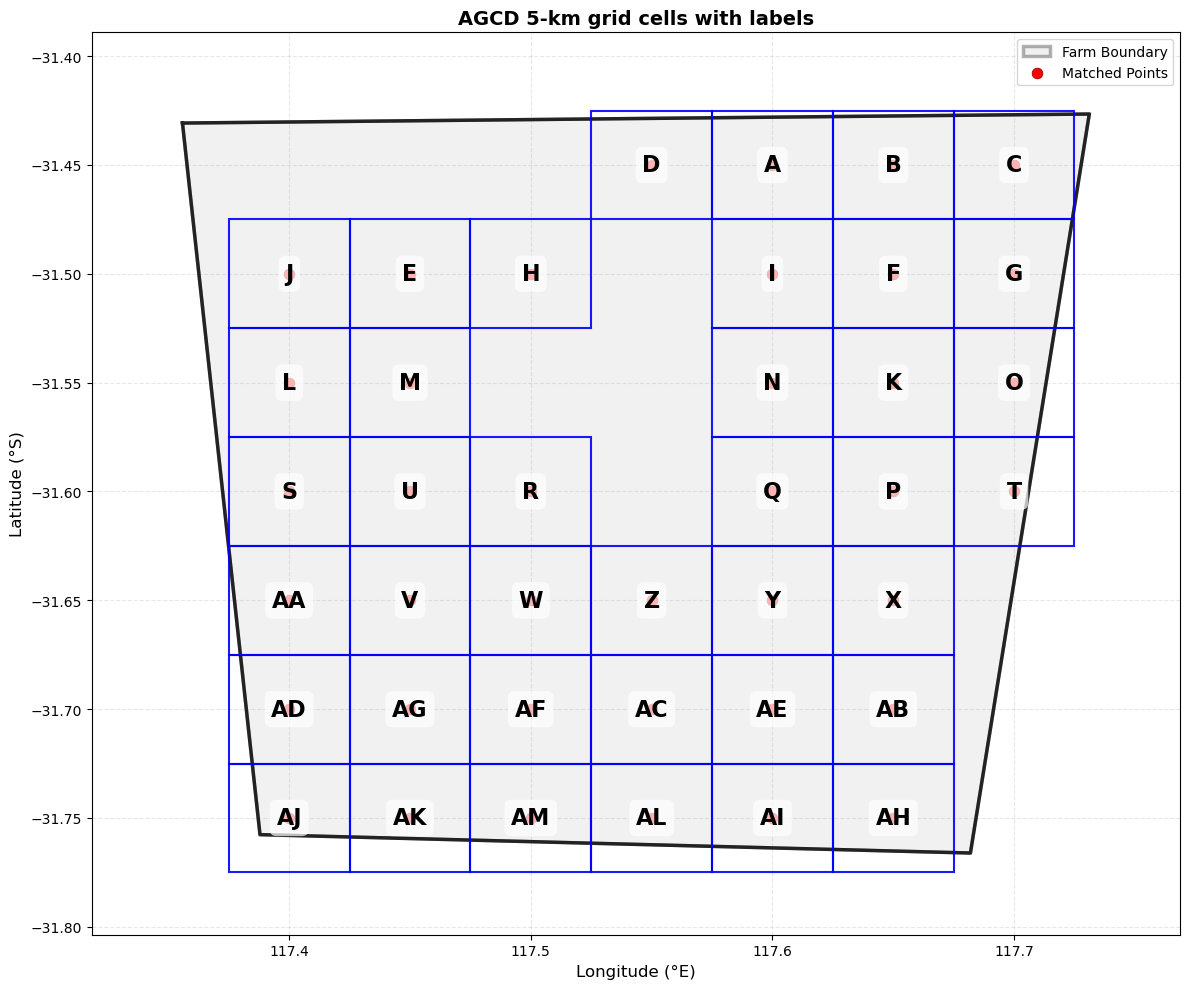


[COMPLETE] Visualizations created!


In [14]:
def create_grid_cell_visualization(matched_coords_path, kml_file_path, output_dir, farm_name):
    """
    Create a visualization showing AGCD 5-km grid cells with matched points and labels.
    
    Parameters:
    -----------
    matched_coords_path : str
        Path to the matched coordinates CSV file
    kml_file_path : str
        Path to the KML file (for farm boundary)
    output_dir : str
        Directory to save the visualization
    farm_name : str
        Name of the farm
    """
    # Load matched coordinates
    matched_df = pd.read_csv(matched_coords_path)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # FIRST: Plot ALL farm boundary polygons from KML as blue outlines (base layer)
    all_polygons = []
    if os.path.exists(kml_file_path):
        all_polygons = parse_kml_file_all_polygons(kml_file_path)
        
        if all_polygons:
            print(f"    Found {len(all_polygons)} polygon(s) in KML file")
            
            # Draw each polygon as a blue outline
            for i, polygon in enumerate(all_polygons):
                # Extract polygon coordinates
                poly_coords = list(polygon.exterior.coords)
                poly_lons = [coord[0] for coord in poly_coords]
                poly_lats = [coord[1] for coord in poly_coords]
                
                # Draw blue outline (like in the reference image)
                ax.plot(
                    poly_lons + [poly_lons[0]], 
                    poly_lats + [poly_lats[0]], 
                    'b-', 
                    linewidth=1.5, 
                    alpha=0.8, 
                    zorder=1,
                    label='Farm Boundary' if i == 0 else ''
                )
        else:
            print(f"    [WARNING] No polygons found in KML file")
    
    # SECOND: Plot matched points (red dots) on top of farm boundary
    ax.scatter(
        matched_df['longitude'],
        matched_df['latitude'],
        c='red',
        s=60,
        zorder=3,
        label='Matched Points',
        edgecolors='darkred',
        linewidths=0.5
    )
    
    # THIRD: Add labels (black capital letters) on top of everything
    for idx, row in matched_df.iterrows():
        ax.text(
            row['longitude'],
            row['latitude'],
            row['label'],
            fontsize=16,
            fontweight='bold',
            color='black',
            ha='center',
            va='center',
            zorder=4,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
        )
    
    # Set axis labels and title
    ax.set_xlabel('Longitude (°E)', fontsize=12)
    ax.set_ylabel('Latitude (°S)', fontsize=12)
    ax.set_title(f'AGCD 5-km grid cells with labels', fontsize=14, fontweight='bold')
    
    # Set axis limits based on all polygons or matched coordinates
    if all_polygons:
        # Calculate bounds from all polygons
        all_bounds = [poly.bounds for poly in all_polygons]  # (minx, miny, maxx, maxy) for each
        min_lon = min(b[0] for b in all_bounds)
        min_lat = min(b[1] for b in all_bounds)
        max_lon = max(b[2] for b in all_bounds)
        max_lat = max(b[3] for b in all_bounds)
        
        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        padding = max(lat_range, lon_range) * 0.1
        
        ax.set_xlim(min_lon - padding, max_lon + padding)
        ax.set_ylim(min_lat - padding, max_lat + padding)
    else:
            # Fallback to matched coordinates
            lat_range = matched_df['latitude'].max() - matched_df['latitude'].min()
            lon_range = matched_df['longitude'].max() - matched_df['longitude'].min()
            padding = max(lat_range, lon_range) * 0.1
            
            ax.set_xlim(
                matched_df['longitude'].min() - padding,
                matched_df['longitude'].max() + padding
            )
            ax.set_ylim(
                matched_df['latitude'].min() - padding,
                matched_df['latitude'].max() + padding
            )
    else:
        # Fallback to matched coordinates
        lat_range = matched_df['latitude'].max() - matched_df['latitude'].min()
        lon_range = matched_df['longitude'].max() - matched_df['longitude'].min()
        padding = max(lat_range, lon_range) * 0.1
        
        ax.set_xlim(
            matched_df['longitude'].min() - padding,
            matched_df['longitude'].max() + padding
        )
        ax.set_ylim(
            matched_df['latitude'].min() - padding,
            matched_df['latitude'].max() + padding
        )
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    output_filename = f"{farm_name}_grid_cells_with_labels.png"
    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"  [OK] Saved visualization: {output_path}")
    
    plt.show()
    
    return fig


# Create visualizations for all processed farms
print(f"\n{'='*70}")
print("Creating Visualizations")
print(f"{'='*70}")

kml_files = glob.glob(os.path.join(KML_DIR, "*.kml"))

if len(kml_files) == 0:
    print(f"  [ERROR] No KML files found in {KML_DIR}")
else:
    for kml_file in kml_files:
        farm_name = Path(kml_file).stem
        
        # Path to matched coordinates CSV
        matched_coords_path = os.path.join(OUTPUT_DIR, f"{farm_name}_grid_coordinates_match.csv")
        
        if os.path.exists(matched_coords_path):
            print(f"\n  Creating visualization for: {farm_name}")
            create_grid_cell_visualization(
                matched_coords_path,
                kml_file,
                OUTPUT_DIR,
                farm_name
            )
        else:
            print(f"  [WARNING] Matched coordinates file not found: {matched_coords_path}")

print(f"\n{'='*70}")
print("[COMPLETE] Visualizations created!")
print(f"{'='*70}")